In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from google.colab.patches import cv2_imshow as imshow
from keras.callbacks import EarlyStopping

# gpu 할당: 데이터 파편화 줄이기 

In [2]:
from tensorflow.compat.v1 import ConfigProto,InteractiveSession

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

print(os.popen('nvidia-smi').read())

Tue Mar  7 12:22:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |    333MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 이미지 제너레이터

In [10]:
df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/3차프로젝트/4.골연령예측/BA_df.pkl")
df

,No,gender,BA_mean,CARPAL,TMCP,MMCP,LMCP,IP,MPIP,LPIP,img_path
0,1,0,4.1,"[0.413333, 0.70375, 0.46, 0.295]","[0.724167, 0.493125, 0.121667, 0.08625]","[0.42, 0.379375, 0.106667, 0.11875]","[0.174167, 0.45375, 0.125, 0.1]","[0.815, 0.40625, 0.0866667, 0.07]","[0.414167, 0.223125, 0.105, 0.07375]","[0.0841667, 0.346875, 0.095, 0.05625]",/content/drive/MyDrive/Colab Notebooks/3차프로...
1,2,0,2.6,"[0.5864666666666667, 0.759375, 0.5354166666666...","[0.8302166666666667, 0.52735, 0.13958333333333...","[0.4864666666666666, 0.4445375, 0.13125, 0.157...","[0.2354166666666666, 0.5398499999999999, 0.158...","[0.8166666666666667, 0.4086, 0.1125, 0.0859375]","[0.4406333333333333, 0.246875, 0.1354166666666...","[0.1416666666666666, 0.4078125, 0.1125, 0.071875]",/content/drive/MyDrive/Colab Notebooks/3차프로...
2,3,0,4.2,"[0.5552166666666667, 0.7070375, 0.41875, 0.242...","[0.81875, 0.5328125, 0.1208333333333333, 0.09375]","[0.4906333333333333, 0.4320375, 0.110416666666...","[0.29375, 0.50625, 0.1208333333333333, 0.090625]","[0.90625, 0.4546875, 0.0833333333333333, 0.0625]","[0.4833333333333333, 0.27735, 0.1, 0.0859375]","[0.2, 0.4109375, 0.0958333333333333, 0.059375]",/content/drive/MyDrive/Colab Notebooks/3차프로...
3,4,0,1.8,"[0.5770833333333333, 0.6539125, 0.425, 0.2984375]","[0.7979166666666667, 0.4382875, 0.125, 0.0984375]","[0.4416666666666666, 0.3828125, 0.1375, 0.121875]","[0.2573, 0.4961, 0.1520833333333333, 0.1046875]","[0.85105, 0.3382875, 0.0979166666666666, 0.085...","[0.3854166666666667, 0.2211, 0.125, 0.0890625]","[0.1552166666666666, 0.3914125, 0.114583333333...",/content/drive/MyDrive/Colab Notebooks/3차프로...
4,5,0,3.1,"[0.5375, 0.754375, 0.505, 0.32625]","[0.803333, 0.495, 0.11, 0.09]","[0.465, 0.415625, 0.113333, 0.12625]","[0.245, 0.52875, 0.12, 0.0875]","[0.855833, 0.3775, 0.0983333, 0.0725]","[0.449167, 0.233125, 0.108333, 0.08125]","[0.133333, 0.41625, 0.0933333, 0.0675]",/content/drive/MyDrive/Colab Notebooks/3차프로...
...,...,...,...,...,...,...,...,...,...,...,...
1232,568,1,16.0,"[0.470833, 0.681875, 0.405, 0.22875]","[0.78, 0.5075, 0.13, 0.0925]","[0.460833, 0.37875, 0.118333, 0.1]","[0.23, 0.436875, 0.12, 0.09375]","[0.870833, 0.406875, 0.095, 0.07375]","[0.464167, 0.206875, 0.118333, 0.07875]","[0.150833, 0.315, 0.118333, 0.0675]",/content/drive/MyDrive/Colab Notebooks/3차프로...
1233,569,1,15.5,"[0.459167, 0.684375, 0.351667, 0.21625]","[0.739167, 0.509375, 0.128333, 0.09125]","[0.433333, 0.3725, 0.11, 0.07]","[0.248333, 0.44875, 0.09, 0.0725]","[0.845833, 0.415625, 0.095, 0.07375]","[0.413333, 0.20875, 0.103333, 0.08]","[0.154167, 0.346875, 0.111667, 0.06125]",/content/drive/MyDrive/Colab Notebooks/3차프로...
1234,570,1,15.2,"[0.53, 0.71625, 0.39, 0.2125]","[0.790833, 0.51875, 0.121667, 0.09]","[0.4925, 0.394375, 0.111667, 0.08875]","[0.303333, 0.510625, 0.113333, 0.08625]","[0.871667, 0.410625, 0.09, 0.06875]","[0.510833, 0.22375, 0.101667, 0.085]","[0.18, 0.405, 0.0866667, 0.075]",/content/drive/MyDrive/Colab Notebooks/3차프로...
1235,571,1,16.5,"[0.495, 0.77375, 0.3, 0.23]","[0.755, 0.60625, 0.116667, 0.095]","[0.5175, 0.428125, 0.095, 0.09125]","[0.324167, 0.505625, 0.115, 0.09375]","[0.855, 0.496875, 0.0966667, 0.07625]","[0.579167, 0.250625, 0.0983333, 0.08125]","[0.22, 0.405, 0.113333, 0.075]",/content/drive/MyDrive/Colab Notebooks/3차프로...


    CARPAL = [] # 0
    TMCP = [] # 1
    MMCP = [] # 2
    LMCP = [] # 3
    IP = [] # 4
    MPIP = [] # 5
    LPIP = [] # 6

In [13]:
def generator(df):
  gender = np.array(df.gender)
  age = np.array(df.BA_mean)

  # ====================== 리스트 생성 ======================
  org_img_li = [] # 원본

  CARPAL_li = [] # 0 : 손목
  TMCP_li = [] # 1 : 엄지 아래
  MMCP_li = [] # 2 : 중지 아래
  LMCP_li = [] # 3 : 새끼 아래
  IP_li = []   # 4 : 엄지 위
  MPIP_li = [] # 5 : 중지 위
  LPIP_li = [] # 6 : 새끼 위
 
  gen_li = []
  age_li = []
  # =============================================================

  li = ['CARPAL',	'TMCP',	'MMCP',	'LMCP',	'IP',	'MPIP',	'LPIP']

  for i in range(len(df)):
    # 원본 이미지 경로 가져오기
    file_name = df.loc[i,'img_path']
    # 원본 이미지 읽어오기
    orgin_img = cv2.imread(file_name)
    
    # ====================== 이미지 크롭 ======================
    ## 이미지 크롭할 좌표 잡기
    for j in li :

      x=df[j][i][0]* 600
      y=df[j][i][0]* 800
      w=df[j][i][0]* 600
      h=df[j][i][0]* 800
  
      half_width=w/2.0
      half_height=h/2.0
  
      startX=int(x-half_width)
      startY=int(y-half_height)
      endX=int(x+half_width)
      endY=int(y+half_height)

      crop_img = orgin_img[startY:endY,startX:endX]

      if j == 'CARPAL' :
        img_CARPAL = cv2.resize(crop_img, (150, 150),cv2.INTER_AREA)
      elif j == 'TMCP' :
        img_TMCP = cv2.resize(crop_img, (50, 50), cv2.INTER_AREA)
      elif j == 'MMCP' :
        img_MMCP = cv2.resize(crop_img, (50, 50), cv2.INTER_AREA)
      elif j == 'LMCP' :
        img_LMCP = cv2.resize(crop_img, (50, 50), cv2.INTER_AREA)
      elif j == 'IP' :
        img_IP = cv2.resize(crop_img, (50, 50), cv2.INTER_AREA)
      elif j == 'MPIP' :
        img_MPIP = cv2.resize(crop_img, (50, 50), cv2.INTER_AREA)
      elif j == "LPIP" :
        img_LPIP = cv2.resize(crop_img, (50, 50), cv2.INTER_AREA)
      else :
        continue
    # =========================================================
   
    # 리스트에 자른 이미지,성별,나이 저장
    ## 성별, 나이
    gen_li.append(gender[i])
    age_li.append(age[i])
    ## 원본 이미지
    img = cv2.resize(orgin_img, (224, 224),cv2.INTER_AREA)
    org_img_li.append(img)
    ## crop img
    CARPAL_li.append(img_CARPAL)
    TMCP_li.append(img_TMCP)
    MMCP_li.append(img_MMCP)
    LMCP_li.append(img_LMCP)
    IP_li.append(img_IP)
    MPIP_li.append(img_MPIP)
    LPIP_li.append(img_LPIP)
    
  
  # ====================== np.array ======================
  ## 원본 이미지
  org_img_li = np.array(org_img_li)
  ## crop 이미지
  CARPAL_li = np.array(CARPAL_li)
  TMCP_li = np.array(TMCP_li)
  MMCP_li = np.array(MMCP_li)
  LMCP_li = np.array(LMCP_li)
  IP_li = np.array(IP_li)
  MPIP_li = np.array(MPIP_li)
  LPIP_li = np.array(LPIP_li)
  ## 성별, 나이
  gen_li = np.array(gen_li)
  age_li = np.array(age_li)
        
  
  return [org_img_li, CARPAL_li, TMCP_li, MMCP_li, LMCP_li, IP_li, MPIP_li, LPIP_li, gen_li],age_li


csv파일 참고
```
x=float(df[j][i].strip("'[]").split(',')[0].strip(" ' ")) * 600
y=float(df[j][i].strip("'[]").split(',')[1].strip(" ' ")) * 800
w=float(df[j][i].strip("'[]").split(',')[2].strip(" ' ")) * 600
h=float(df[j][i].strip("'[]").split(',')[3].strip(" ' ")) * 800
```

# TJNet 모델 학습

## 모델 생성

In [14]:
def tjnet_g(shape_size, act='swish'):
  input = Input(shape = (shape_size, shape_size, 3))
    
  #block 1
  conv1 = ReLU()(Conv2D(32,3)(input))
  conv2 = ReLU()(Conv2D(32,3)(conv1))
  conv3 = ReLU()(Conv2D(64,3,padding='same')(conv2))
  x = Conv2D(64,1)(conv3)
  x = BatchNormalization()(x)

  se = GlobalAveragePooling2D()(x)
  se = Dense(4,activation=act)(se)
  se = Dense(64,activation=act)(se)
  se = Reshape([1,1,64])(se)
  x = Multiply()([conv3,se])

  short = Conv2D(64,(1,1))(conv2)
  short = BatchNormalization()(short)

  x = ReLU()(add([x,short]))

  pool1 = MaxPool2D(pool_size=(2,2))(x)
  #block 2
  conv4 = ReLU()(Conv2D(80,1)(pool1))
  conv5 = ReLU()(Conv2D(192,3)(conv4))
  pool2 = MaxPool2D(pool_size=(2,2))(conv5)
  #block 3
  conv6 = ReLU()(Conv2D(512,3)(pool2))
  pool3 = MaxPool2D(pool_size=(2,2))(conv6)
  #block 4
  conv7 = ReLU()(Conv2D(1024,3,padding='same')(pool3))
  pool4 = MaxPool2D(pool_size=(2,2))(conv7)
  i_output = Flatten()(pool4)

  model = Model(inputs = input, outputs = i_output)

  return model

In [15]:
def tjnet(img_size = 224):
    
    #원본이미지 모델 (mobilnet)
    mob_model = tf.keras.applications.MobileNet(input_shape = (img_size, img_size, 3),
                                                   include_top = False,
                                                   weights = 'imagenet')
    mob_model.trainable = True
    model_2 = Sequential()
    model_2.add(mob_model)
    model_2.add(GlobalAveragePooling2D())
    model_2.add(Dense(2048, activation = 'swish'))
    # ------------------------------------------------------------------------------------------------
    CARPAL_model = tjnet_g(150)
    TMCP_model = tjnet_g(50)
    MMCP_model = tjnet_g(50)
    LMCP_model = tjnet_g(50)
    IP_model = tjnet_g(50)
    MPIP_model = tjnet_g(50)
    LPIP_model = tjnet_g(50)
    # ------------------------------------------------------------------------------------------------
    # gender 모델
    g_model = gender()

    #concat및 마무리
    con1 = concatenate([model_2.output, CARPAL_model.output, TMCP_model.output, MMCP_model.output, LMCP_model.output, IP_model.output, MPIP_model.output, LPIP_model.output])
    dense1 = ReLU()(Dense(2048)(con1))
    con2 = concatenate([dense1,g_model.output])
    dense2 = ReLU()(Dense(1024)(con2))
    dense3 = ReLU()(Dense(512)(dense2))
    model_out = Dense(1,activation = "linear")(dense3)

    model = Model([model_2.input, CARPAL_model.input, TMCP_model.input, MMCP_model.input,LMCP_model.input, IP_model.input, MPIP_model.input, LPIP_model.input, g_model.input],model_out)

    return model

In [16]:
def gender(act='swish'):
    g_input = Input(shape = (1,))
    g_output = Dense(64,activation = act)(g_input)
    
    g_model = Model(inputs = g_input,outputs = g_output)
    return g_model

## 모델 설정

In [17]:
model = tjnet()

model.compile(loss ='mse', optimizer= 'nadam', metrics = 'mae' )

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 50, 50, 3)]  0           []                         

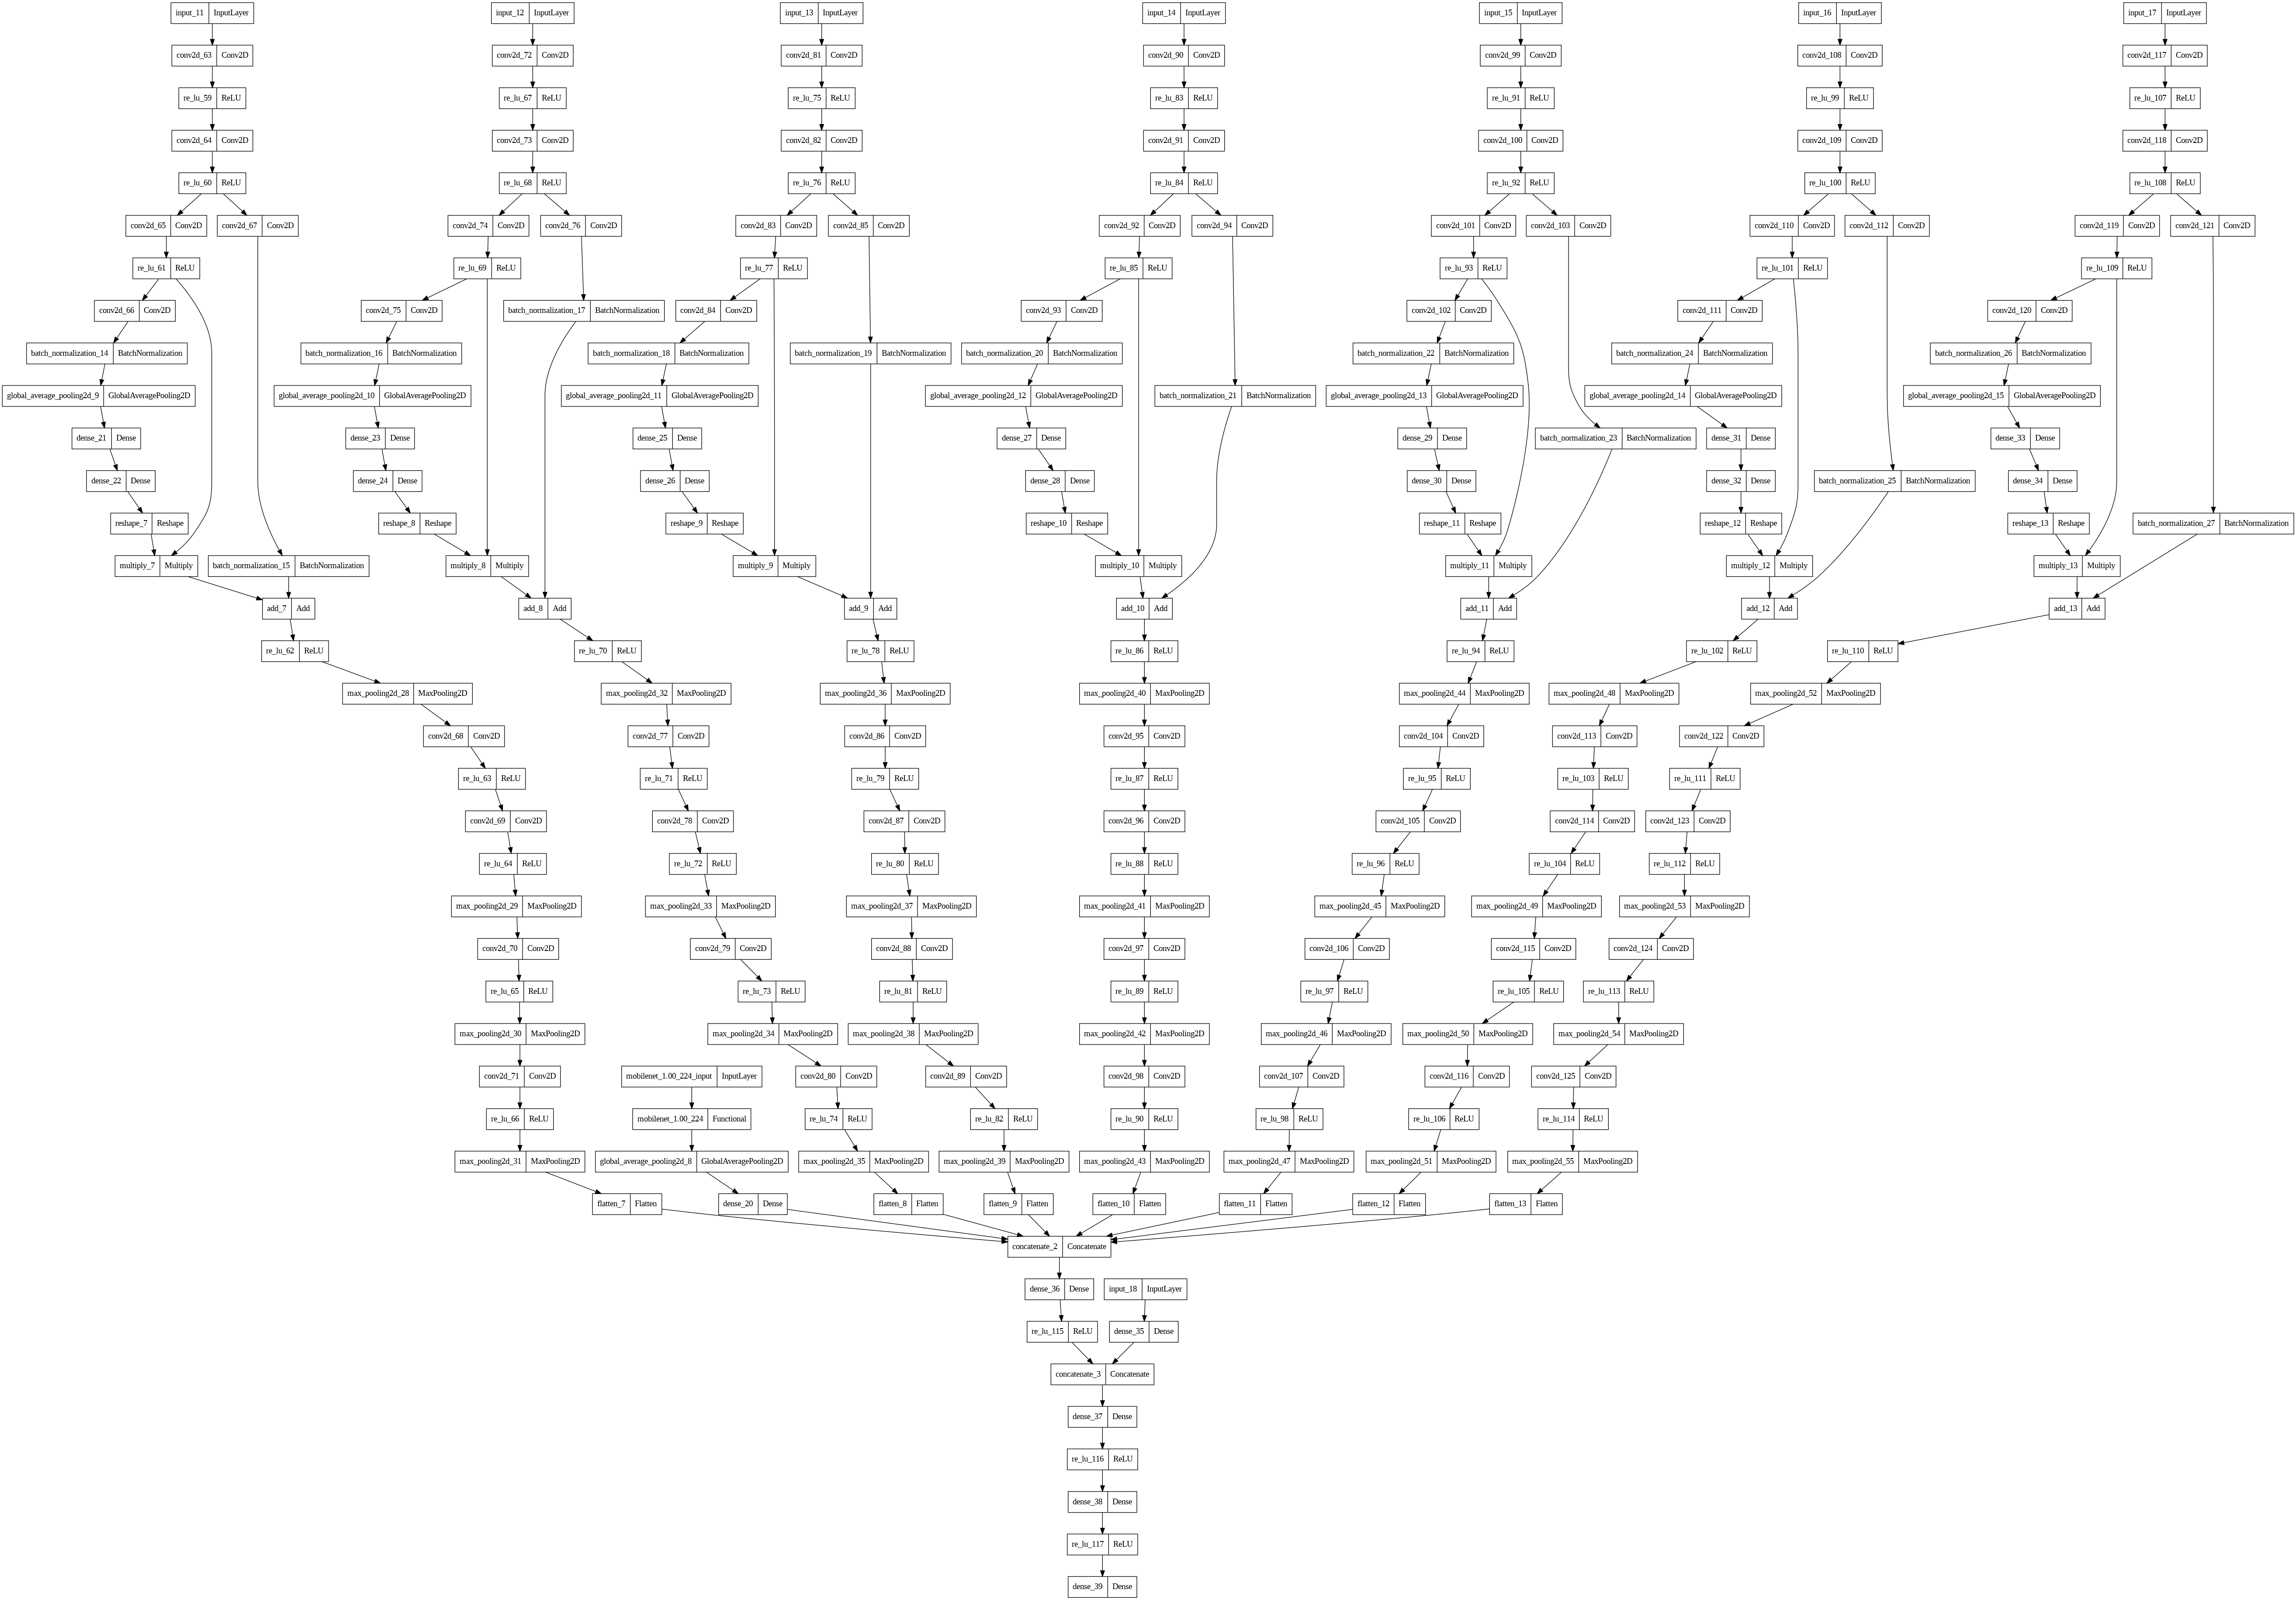

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model)

## train_val_set 만들기 / 제너레이터 적용


In [18]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 0)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_X,train_y = generator(train_df)
val_X,val_y = generator(val_df)

In [19]:
len(train_df), len(val_df)

(989, 248)

In [20]:
len(train_y),len(val_y)

(989, 248)

## 모델 학습

## 첫 로스값 제거

In [21]:
model.fit(train_X,train_y, validation_data = (val_X, val_y), epochs = 1)

31/31 [==============================] - 116s 872ms/step - loss: 3136.2915 - mae: 13.2683 - val_loss: 164.3074 - val_mae: 12.6913


## 콜백 + fit

**ReduceLROnPlateau**<br>

모델의 개선이 없을 경우, Learning Rate를 조절해 모델의 개선을 유도하는 콜백함수

```
monitor   - ReduceLROnPlateau의 기준이 되는 값을 입력
          - 만약 'val_loss'를 입력하면 val_loss가 더이상 감소되지 않을 경우 ReduceLROnPlateau을 적용

factor    - Learning rate를 얼마나 감소시킬 지 정하는 인자값
          - 새로운 learning rate는 기존 learning rate * factor

mode      - monitor되는 값이 최소가 되어야 하는지, 최대가 되어야 하는지 알려주는 인자

min_delta - 개선된 것으로 간주하기 위한 최소한의 변화량

min_lr    - Learning rate의 하한선
```



In [22]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=30,
                              verbose=0, mode='auto')

rLR = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback이 호출됩니다
    factor=0.5,          # callback 호출시 학습률을 1/2로 줄입니다
    patience=10,         # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
)

callbacks = [early_stopping,rLR]
#================================================================#
epochs = 50

history = model.fit(train_X,train_y,
                    validation_data = (val_X,val_y),
                    epochs = epochs,
                    callbacks= callbacks)

Epoch 1/50
31/31 [==============================] - 17s 551ms/step - loss: 1.4425 - mae: 0.9273 - val_loss: 87.4562 - val_mae: 9.2629 - lr: 0.0010
Epoch 2/50
31/31 [==============================] - 17s 544ms/step - loss: 0.9568 - mae: 0.7744 - val_loss: 31.4530 - val_mae: 5.4679 - lr: 0.0010
Epoch 3/50
31/31 [==============================] - 16s 529ms/step - loss: 0.7110 - mae: 0.6706 - val_loss: 23.0507 - val_mae: 4.5865 - lr: 0.0010
Epoch 4/50
31/31 [==============================] - 16s 525ms/step - loss: 0.5749 - mae: 0.5883 - val_loss: 25.3970 - val_mae: 4.8872 - lr: 0.0010
Epoch 5/50
31/31 [==============================] - 16s 528ms/step - loss: 0.4375 - mae: 0.5154 - val_loss: 24.3542 - val_mae: 4.8181 - lr: 0.0010
Epoch 6/50
31/31 [==============================] - 16s 533ms/step - loss: 0.4013 - mae: 0.4805 - val_loss: 16.2240 - val_mae: 3.8117 - lr: 0.0010
Epoch 7/50
31/31 [==============================] - 17s 536ms/step - loss: 0.3385 - mae: 0.4518 - val_loss: 9.2673 - v

# 예측/평가

## 그래프 확인

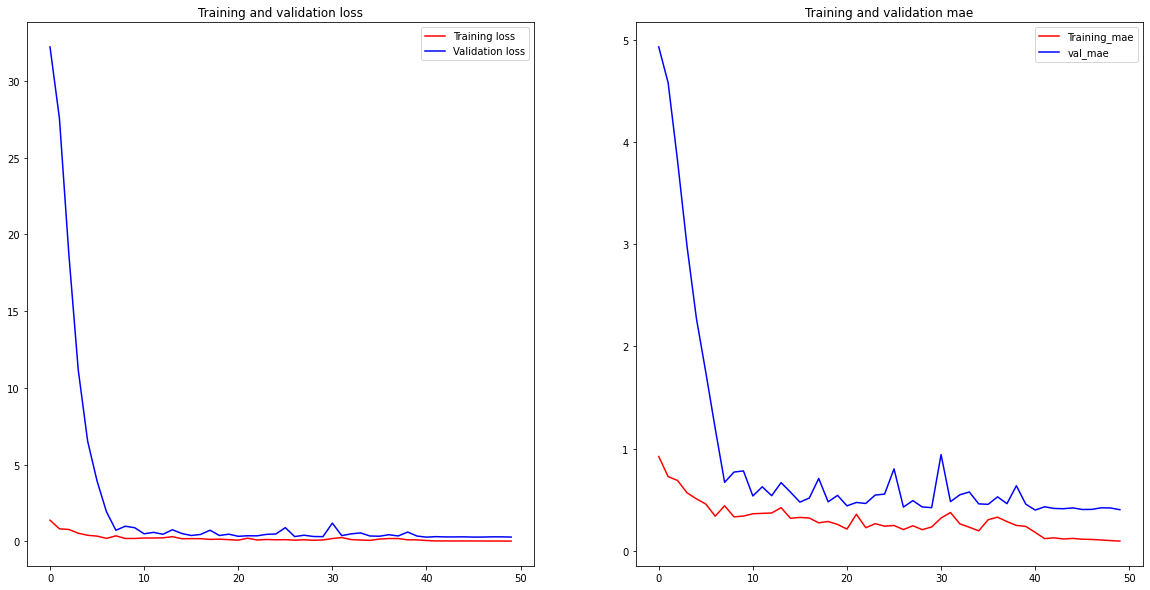

In [ ]:
# train 검증의 손실과 정확도 시각화
history = history.history

loss = history['loss']
val_loss = history['val_loss']
mean_squared_error = history['mae']
val_mean_squared_error = history['val_mae']

epochs = range(len(loss))

# 한 이미지로 보기 위하여 서브플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

axs[0].plot(epochs, loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].legend(loc=0)

axs[1].plot(epochs, mean_squared_error, 'r', label='Training_mae')
axs[1].plot(epochs, val_mean_squared_error, 'b', label='val_mae')
axs[1].set_title('Training and validation mae')
axs[1].legend(loc=0)

## 평가

In [23]:
mse, mae = model.evaluate(val_X,val_y)
print(f"mae : {mae}, mse : {mse}" )

8/8 [==============================] - 1s 124ms/step - loss: 0.3066 - mae: 0.4289
mae : 0.4288707971572876, mse : 0.30656519532203674


## 데이터프레임에 예측값 추가

In [24]:
pred1 = model.predict(train_X)
pred2 = model.predict(val_X)

8/8 [==============================] - 1s 126ms/step


In [25]:
print(len(pred1),len(train_df))

989 989


In [26]:
print(len(pred2),len(val_df))

248 248


In [28]:
train_df['BA_pred'] = pred1
val_df['BA_pred'] = pred2

final_df = pd.concat([train_df,val_df])
final_df.sort_values(['gender','No'],ignore_index=True, inplace=True)

In [29]:
final_df

,No,gender,BA_mean,CARPAL,TMCP,MMCP,LMCP,IP,MPIP,LPIP,img_path,BA_pred
0,1,0,4.1,"[0.413333, 0.70375, 0.46, 0.295]","[0.724167, 0.493125, 0.121667, 0.08625]","[0.42, 0.379375, 0.106667, 0.11875]","[0.174167, 0.45375, 0.125, 0.1]","[0.815, 0.40625, 0.0866667, 0.07]","[0.414167, 0.223125, 0.105, 0.07375]","[0.0841667, 0.346875, 0.095, 0.05625]",/content/drive/MyDrive/Colab Notebooks/3차프로...,4.193449
1,2,0,2.6,"[0.5864666666666667, 0.759375, 0.5354166666666...","[0.8302166666666667, 0.52735, 0.13958333333333...","[0.4864666666666666, 0.4445375, 0.13125, 0.157...","[0.2354166666666666, 0.5398499999999999, 0.158...","[0.8166666666666667, 0.4086, 0.1125, 0.0859375]","[0.4406333333333333, 0.246875, 0.1354166666666...","[0.1416666666666666, 0.4078125, 0.1125, 0.071875]",/content/drive/MyDrive/Colab Notebooks/3차프로...,3.089182
2,3,0,4.2,"[0.5552166666666667, 0.7070375, 0.41875, 0.242...","[0.81875, 0.5328125, 0.1208333333333333, 0.09375]","[0.4906333333333333, 0.4320375, 0.110416666666...","[0.29375, 0.50625, 0.1208333333333333, 0.090625]","[0.90625, 0.4546875, 0.0833333333333333, 0.0625]","[0.4833333333333333, 0.27735, 0.1, 0.0859375]","[0.2, 0.4109375, 0.0958333333333333, 0.059375]",/content/drive/MyDrive/Colab Notebooks/3차프로...,4.278206
3,4,0,1.8,"[0.5770833333333333, 0.6539125, 0.425, 0.2984375]","[0.7979166666666667, 0.4382875, 0.125, 0.0984375]","[0.4416666666666666, 0.3828125, 0.1375, 0.121875]","[0.2573, 0.4961, 0.1520833333333333, 0.1046875]","[0.85105, 0.3382875, 0.0979166666666666, 0.085...","[0.3854166666666667, 0.2211, 0.125, 0.0890625]","[0.1552166666666666, 0.3914125, 0.114583333333...",/content/drive/MyDrive/Colab Notebooks/3차프로...,1.658265
4,5,0,3.1,"[0.5375, 0.754375, 0.505, 0.32625]","[0.803333, 0.495, 0.11, 0.09]","[0.465, 0.415625, 0.113333, 0.12625]","[0.245, 0.52875, 0.12, 0.0875]","[0.855833, 0.3775, 0.0983333, 0.0725]","[0.449167, 0.233125, 0.108333, 0.08125]","[0.133333, 0.41625, 0.0933333, 0.0675]",/content/drive/MyDrive/Colab Notebooks/3차프로...,3.071634
...,...,...,...,...,...,...,...,...,...,...,...,...
1232,568,1,16.0,"[0.470833, 0.681875, 0.405, 0.22875]","[0.78, 0.5075, 0.13, 0.0925]","[0.460833, 0.37875, 0.118333, 0.1]","[0.23, 0.436875, 0.12, 0.09375]","[0.870833, 0.406875, 0.095, 0.07375]","[0.464167, 0.206875, 0.118333, 0.07875]","[0.150833, 0.315, 0.118333, 0.0675]",/content/drive/MyDrive/Colab Notebooks/3차프로...,16.094114
1233,569,1,15.5,"[0.459167, 0.684375, 0.351667, 0.21625]","[0.739167, 0.509375, 0.128333, 0.09125]","[0.433333, 0.3725, 0.11, 0.07]","[0.248333, 0.44875, 0.09, 0.0725]","[0.845833, 0.415625, 0.095, 0.07375]","[0.413333, 0.20875, 0.103333, 0.08]","[0.154167, 0.346875, 0.111667, 0.06125]",/content/drive/MyDrive/Colab Notebooks/3차프로...,15.965637
1234,570,1,15.2,"[0.53, 0.71625, 0.39, 0.2125]","[0.790833, 0.51875, 0.121667, 0.09]","[0.4925, 0.394375, 0.111667, 0.08875]","[0.303333, 0.510625, 0.113333, 0.08625]","[0.871667, 0.410625, 0.09, 0.06875]","[0.510833, 0.22375, 0.101667, 0.085]","[0.18, 0.405, 0.0866667, 0.075]",/content/drive/MyDrive/Colab Notebooks/3차프로...,15.327578
1235,571,1,16.5,"[0.495, 0.77375, 0.3, 0.23]","[0.755, 0.60625, 0.116667, 0.095]","[0.5175, 0.428125, 0.095, 0.09125]","[0.324167, 0.505625, 0.115, 0.09375]","[0.855, 0.496875, 0.0966667, 0.07625]","[0.579167, 0.250625, 0.0983333, 0.08125]","[0.22, 0.405, 0.113333, 0.075]",/content/drive/MyDrive/Colab Notebooks/3차프로...,16.674793


In [30]:
final_df.to_csv('/content/drive/MyDrive/Colab Notebooks/3차프로젝트/5.키성장예측/BA_df_f.csv',index=False)

In [ ]:
model_name = "tjnet"
model_weight = model_name +"_weight.h5"
model.save("/content/drive/MyDrive/Colab Notebooks/3차프로젝트/4.골연령예측/model_result/"+model_name+"_epoch_50.h5")